## Imports and Loads

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from importlib import reload
import src.utils.utils
reload(src.utils.utils)

<module 'src.utils.utils' from '/Users/abbassi/Desktop/NAJMEDDINE/EPFL/ADA/Projet/ada-2024-project-melyn/src/utils/utils.py'>

In [2]:
data_folder = './data/'
pickle_folder = data_folder + 'pickle/'
imdb_folder = data_folder + 'IMDB/'
cmu_folder = data_folder + 'CMU/'

with open(pickle_folder + 'movies_clean.p', 'rb') as f:
    movie_data = pickle.load(f)

## Preparation of the data for the modeling

In [3]:
df_mod = movie_data.copy()

In [4]:
df_mod.columns

Index(['Wikipedia_movie_ID', 'Movie_name', 'Movie_box_office_revenue', 'Year',
       'Year_Interval', 'nb_of_Genres', 'Genre_Action',
       'Genre_Action/Adventure', 'Genre_Adventure', 'Genre_Animation',
       'Genre_Biographical film', 'Genre_Biography', 'Genre_Black comedy',
       'Genre_Black-and-white', 'Genre_Bollywood', 'Genre_Chinese Movies',
       'Genre_Comedy', 'Genre_Comedy film', 'Genre_Comedy-drama',
       'Genre_Crime Fiction', 'Genre_Crime Thriller', 'Genre_Documentary',
       'Genre_Drama', 'Genre_Family Drama', 'Genre_Family Film',
       'Genre_Fantasy', 'Genre_Film adaptation', 'Genre_Horror', 'Genre_Indie',
       'Genre_Japanese Movies', 'Genre_LGBT', 'Genre_Musical', 'Genre_Mystery',
       'Genre_Other', 'Genre_Period piece', 'Genre_Psychological thriller',
       'Genre_Romance Film', 'Genre_Romantic comedy', 'Genre_Romantic drama',
       'Genre_Science Fiction', 'Genre_Short Film', 'Genre_Silent film',
       'Genre_Sports', 'Genre_Thriller', 'Genre_War

In [5]:
"""
# Convert the Year_interval column to a categorical column
categorical_columns = ['Year_Interval']
other_columns = [col for col in df_mod.columns if col not in categorical_columns]
year_interval = pd.get_dummies(df_mod[categorical_columns])
df_mod_encoded = pd.concat([df_mod[other_columns], year_interval], axis=1)
df_mod_encoded
"""

# Drop some columns
df_mod.drop(columns=['Movie_box_office_revenue', 'Movie_name', 'Wikipedia_movie_ID', 'Year_Interval'], inplace=True)

In [6]:
df_mod[df_mod.isnull().any(axis=1)]

,Year,nb_of_Genres,Genre_Action,Genre_Action/Adventure,Genre_Adventure,Genre_Animation,Genre_Biographical film,Genre_Biography,Genre_Black comedy,Genre_Black-and-white,...,Country_Germany,Country_Hong Kong,Country_India,Country_Italy,Country_Japan,Country_Other,Country_United Kingdom,Country_United States of America,averageRating,numVotes


In [7]:
df_mod.dtypes

Year                                  int64
nb_of_Genres                          int64
Genre_Action                           bool
Genre_Action/Adventure                 bool
Genre_Adventure                        bool
                                     ...   
Country_Other                          bool
Country_United Kingdom                 bool
Country_United States of America       bool
averageRating                       float64
numVotes                            float64
Length: 69, dtype: object

## Modeling

In [8]:
# Define features and target
X = df_mod.drop(columns=['averageRating'])
y = df_mod['averageRating']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

### Linear Regression

In [9]:
from sklearn.linear_model import LinearRegression

# Train a linear regression model
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
print("Linear regression MSE: ", mse_lr)
print("Linear regression R2: ", r2_lr)

Linear regression MSE:  0.6924186541541993
Linear regression R2:  0.37063273413298137


### Ridge Regression

In [10]:
from sklearn.linear_model import Ridge

# Train and predict a Ridge regression model
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)
y_pred_ridge = ridge.predict(X_test_scaled)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)
print("Ridge regression MSE: ", mse_ridge)
print("Ridge regression R2: ", r2_ridge)

Ridge regression MSE:  0.6924208056160873
Ridge regression R2:  0.37063077858242266


### Random Forest

In [11]:
from sklearn.ensemble import RandomForestRegressor

# Train and predict a Random Forest model
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print("Random Forest MSE: ", mse_rf)
print("Random Forest R2: ", r2_rf)

Random Forest MSE:  0.488091384103702
Random Forest R2:  0.5563540380323351


### XGBoost

In [14]:
from xgboost import XGBRegressor

# Train an XGBoost model
xgb = XGBRegressor(random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
print("XGBoost MSE: ", mse_xgb)
print("XGBoost R2: ", r2_xgb)

XGBoost MSE:  0.45747145694286484
XGBoost R2:  0.5841857258741414


### Bagging Regressor

In [15]:
from sklearn.ensemble import BaggingRegressor

# Train a Baggging Regressor model
bag = BaggingRegressor(random_state=42)
bag.fit(X_train, y_train)
y_pred_bag = bag.predict(X_test)
mse_bag = mean_squared_error(y_test, y_pred_bag)
r2_bag = r2_score(y_test, y_pred_bag)
print("Bagging Regressor MSE: ", mse_bag)
print("Bagging Regressor R2: ", r2_bag)

Bagging Regressor MSE:  0.5489773547967264
Bagging Regressor R2:  0.5010123214641466


### Gradient Boosting Regressor

In [16]:
from sklearn.ensemble import GradientBoostingRegressor

# Train a Gradient Boosting model
gb = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)
mse_gb = mean_squared_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)
print("Gradient Boosting MSE: ", mse_gb)
print("Gradient Boosting R2: ", r2_gb)

Gradient Boosting MSE:  0.502887360283913
Gradient Boosting R2:  0.5429053780077898


### Decision Tree

In [17]:
from sklearn.tree import DecisionTreeRegressor

# Train a Decision Tree model
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
mse_dt = mean_squared_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)
print("Decision Tree MSE: ", mse_dt)
print("Decision Tree R2: ", r2_dt)

Decision Tree MSE:  0.946131625967838
Decision Tree R2:  0.14002277233119298


## Comparison the mean squared error of the models

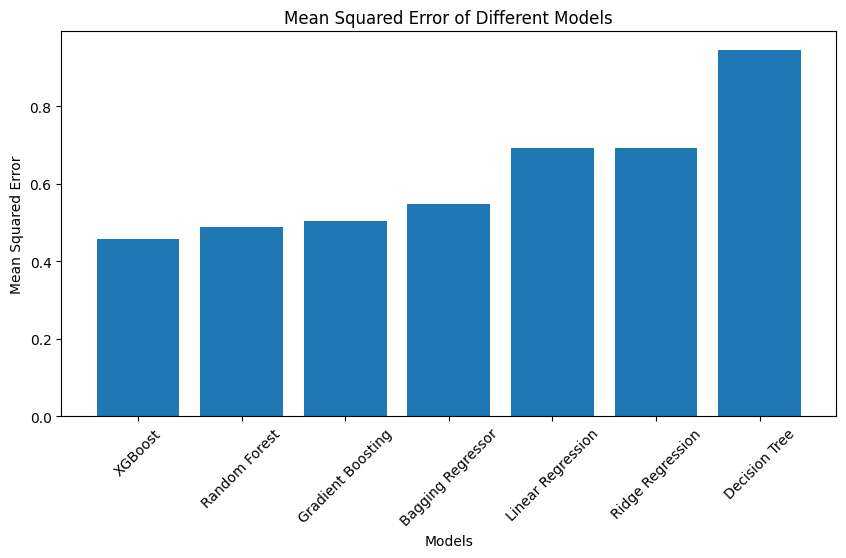

In [18]:
# Comparison the mean squared error of the models
models = ['Linear Regression', 'Ridge Regression', 'Random Forest', 'XGBoost', 'Bagging Regressor', 'Gradient Boosting', 'Decision Tree']
errors = [mse_lr, mse_ridge, mse_rf, mse_xgb, mse_bag, mse_gb, mse_dt]

sorted_pairs = sorted(zip(errors, models))
sorted_errors, sorted_models = zip(*sorted_pairs)

plt.figure(figsize=(10, 5))
plt.bar(sorted_models, sorted_errors)
plt.xlabel('Models')
plt.ylabel('Mean Squared Error')
plt.title('Mean Squared Error of Different Models')
plt.xticks(rotation=45)
plt.show()

## Feature Importance of the two best models

XGBoost feature importance:                               Feature  Importance
17                 Genre_Documentary    0.195586
23                      Genre_Horror    0.065809
44                      lang_english    0.065069
18                       Genre_Drama    0.059122
66  Country_United States of America    0.052045
..                               ...         ...
45                       lang_french    0.003129
6            Genre_Biographical film    0.002869
40                    Genre_War film    0.002846
11              Genre_Chinese Movies    0.002777
59                   Country_Germany    0.002615

[68 rows x 2 columns]


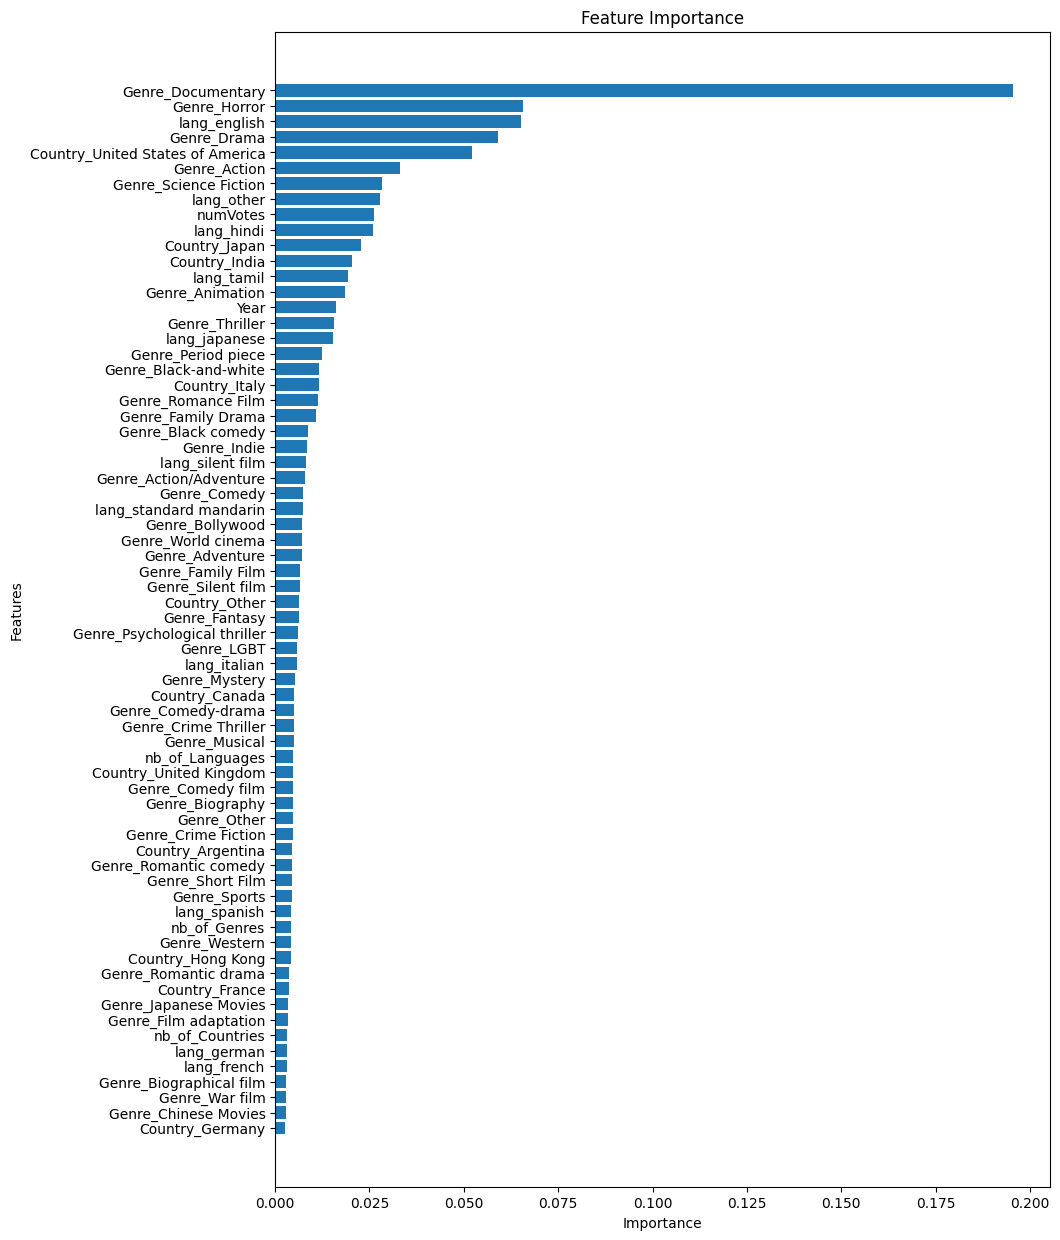

In [19]:
# Get feature importance for the XGBoost model
importance_df_xgb = pd.DataFrame({'Feature': X.columns, 'Importance': xgb.feature_importances_}).sort_values(by='Importance', ascending=False)
print("XGBoost feature importance: ", importance_df_xgb)

# Plot the feature importance for the XGBoost model
plt.figure(figsize=(10, 15))
plt.barh(importance_df_xgb['Feature'], importance_df_xgb['Importance'])
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

Random Forest feature importance:                   Feature  Importance
67              numVotes    0.290543
0                   Year    0.172243
18           Genre_Drama    0.063006
17     Genre_Documentary    0.051637
1           nb_of_Genres    0.044346
..                   ...         ...
36      Genre_Short Film    0.000922
11  Genre_Chinese Movies    0.000751
37     Genre_Silent film    0.000698
51      lang_silent film    0.000474
56     Country_Argentina    0.000373

[68 rows x 2 columns]


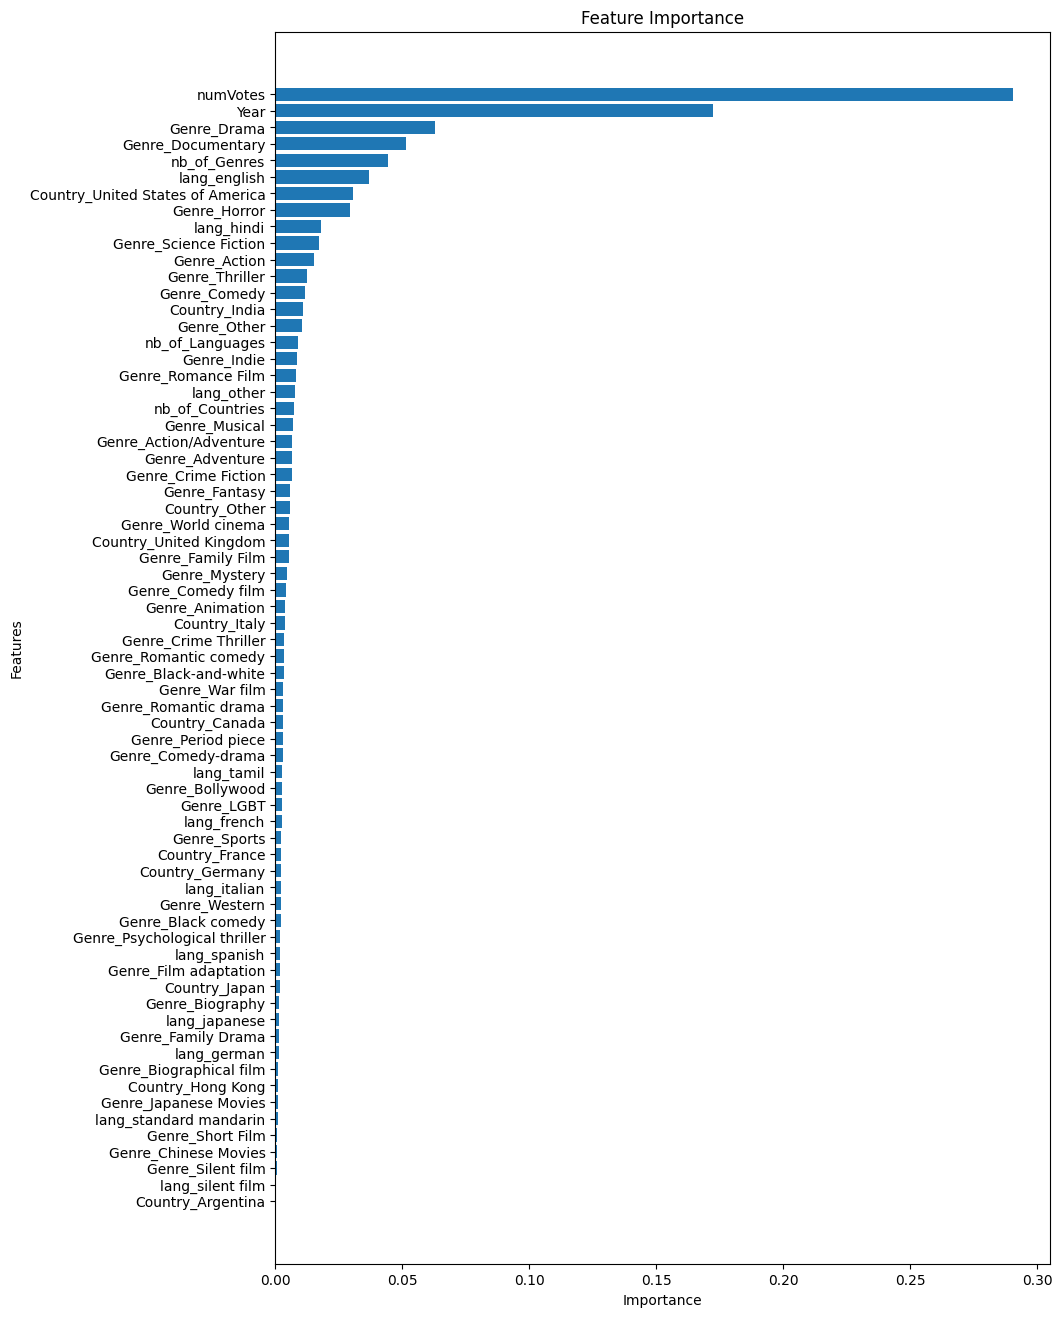

In [20]:
# Get feature importance for Random Forest model
importance_df_RF = pd.DataFrame({'Feature': X.columns, 'Importance': rf.feature_importances_}).sort_values(by='Importance', ascending=False)
print("Random Forest feature importance: ", importance_df_RF)

# Plot the feature importance for the Random Forest model
plt.figure(figsize=(10, 16))
plt.barh(importance_df_RF['Feature'], importance_df_RF['Importance'])
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()